
# Simple reconstruction of a fully sampled 2D FFE scan

The reconstruction performed in this file consists of the following steps:

  1. Download the rawdata from github (https://github.com/GyroTools/precon-examples)
  2. Initialize the reconstruction and read the parameters
  3. Read the data and create a k-space  
  4. Perform fourier transformation and half-scan reconstruction
  5. Perform image production
  6. Cleanup

## Download a Philips raw dataset from github

In [ ]:
import tempfile
import zipfile
from pathlib import Path

import requests

data_url = 'https://github.com/GyroTools/precon-examples/blob/master/data/ffe_2d.zip?raw=true'
temp_dir = tempfile.mkdtemp()
rawfile_zip = Path(temp_dir) / 'ffe_2d.zip'
response = requests.get(data_url)
if response.status_code == 200:
    with open(rawfile_zip, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully and saved to {rawfile_zip}")
    # unzip the file
    with zipfile.ZipFile(rawfile_zip, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
        rawfile = Path(temp_dir) / 're_02092020_1208365_2_2_wip_normal_ffeV4.raw'
        if not rawfile.exists():
            raise FileNotFoundError(f"Failed to find the raw file {rawfile}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully and saved to C:\Users\piwo7\AppData\Local\Temp\tmpve3pp0he\ffe_2d.zip


## Initialize the reconstruction and read parameters

In [ ]:
import precon as pr

# read parameter
pars = pr.Parameter(rawfile)

# define what to read
parameter2read = pr.Parameter2Read(pars.labels)
parameter2read.stack = 0
parameter2read.mix = 0

# disable performance logging (reconstruction times)
pars.performance_logging = False

print(f'TR / TE: {pars.get_value("IF_act_rep_time_echo_time", at=0)}')
print(f'Acquired Matrix Size: {pars.get_value("IF_meas_matrix_size", at=0)}')
print(f'Acquired Voxel Size: {pars.get_value("IF_meas_voxel_size", at=0)}')
print(f'Reconstructed Voxel Size: {pars.get_value("IF_recon_voxel_size", at=0)}')

TR / TE: 2.9 / 1.46
Acquired Matrix Size: 320 x 155
Acquired Voxel Size: 1.00 / 1.50 / 8.00
Reconstructed Voxel Size: 0.63 / 0.63 / 8.00


## Read the data and create a k-space 

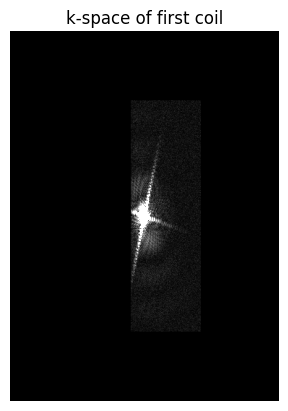

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# read data
with open(pars.rawfile, "rb") as raw:
    data, labels = pr.read(raw, parameter2read, pars.labels, pars.coil_info)

# sort and zero fill data (create k-space)
cur_recon_resolution = pars.get_recon_resolution(xovs=False, yovs=True, zovs=True)
data, labels = pr.sort(data, labels, output_size=cur_recon_resolution)

# plot the k-space (note that it is a half scan acquisition)
plt.title('k-space of first coil')
first_slice = np.abs(data[:,:,0,0,0,0,0,0,0,0,0,0])
vmin = np.min(first_slice)
vmax = 0.015*np.max(first_slice)
plt.imshow(first_slice, cmap='gray', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.show()

## Perform fourier transformation and half scan reconstruction

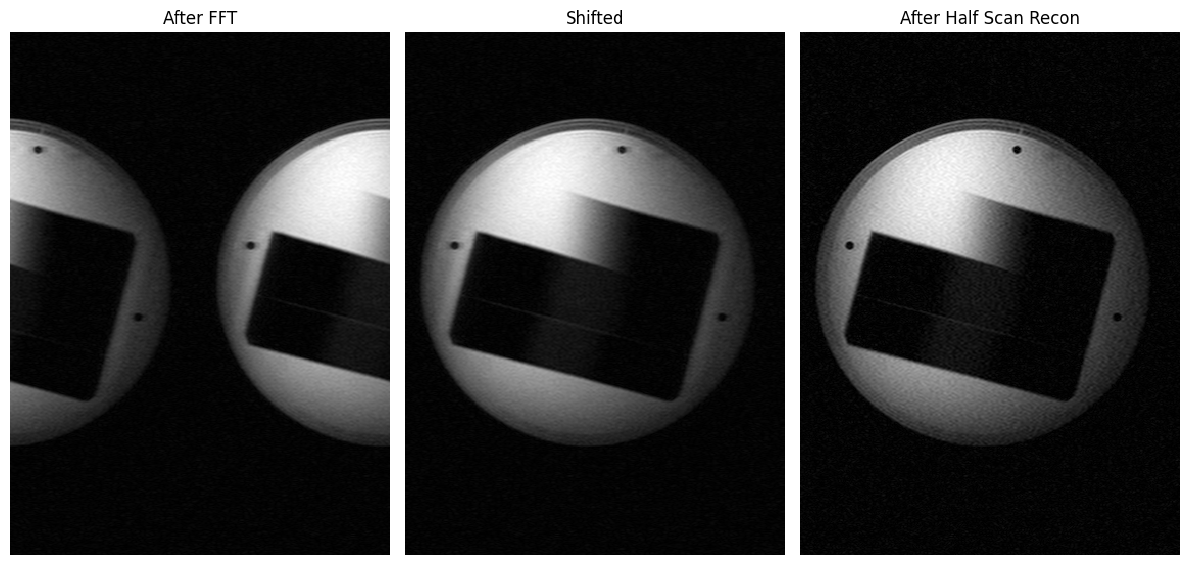

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# FFT
data = pr.k2i(data, axis=(0, 1, 2))

axes[0].imshow(np.abs(data[:,:,0,0,0,0,0,0,0,0,0,0]), cmap='gray', interpolation='nearest')
axes[0].set_title(f'After FFT')
axes[0].axis('off')

# shift data in image space
yshift = pars.get_shift(enc=1)
zshift = pars.get_shift(enc=2)
if yshift:
    data = np.roll(data, yshift, axis=1)
if zshift:
    data = np.roll(data, zshift, axis=2)


axes[1].imshow(np.abs(data[:,:,0,0,0,0,0,0,0,0,0,0]), cmap='gray', interpolation='nearest')
axes[1].set_title(f'Shifted')
axes[1].axis('off')

# partial fourier reconstruction
kx_range = pars.get_range(enc=0, ovs=False)
ky_range = pars.get_range(enc=1)
kz_range = pars.get_range(enc=2)
if pr.is_partial_fourier(kx_range) or pr.is_partial_fourier(ky_range) or pr.is_partial_fourier(kz_range):
    data = pr.homodyne(data, kx_range, ky_range, kz_range)

axes[2].imshow(np.abs(data[:,:,0,0,0,0,0,0,0,0,0,0]), cmap='gray', interpolation='nearest')
axes[2].set_title(f'After Half Scan Recon')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Perform the rest of image production

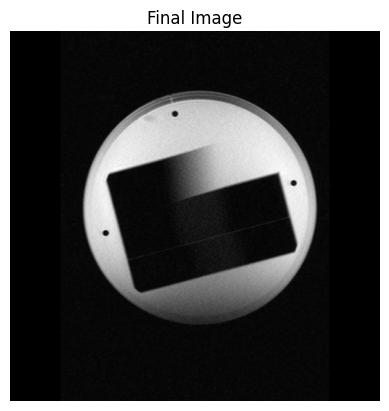

In [ ]:
# combine coils with a sum-of squares combination
data = pr.sos(data, axis=3)

# perform geometry correction
r, gys, gxc, gz = pars.get_geo_corr_pars()
locations = pr.utils.get_unique(labels, "loca")
MPS_to_XYZ = pars.get_transformation_matrix(loca=locations, target=pr.Enums.XYZ)
voxel_sizes = pars.get_voxel_sizes()
data = pr.geo_corr(data, MPS_to_XYZ, r, gys, gxc, gz, voxel_sizes=voxel_sizes)

# remove the oversampling
yovs = pars.get_oversampling(enc=1)
zovs = pars.get_oversampling(enc=2)
data = pr.crop(data, axis=(1, 2), factor=(yovs, zovs), where="symmetric")

# transform the images into the radiological convention
data = pr.format(data, pars.get_in_plane_transformation())

# make the image square
res = max(data.shape[0], data.shape[1])
data = pr.zeropad(data, (res, res), axis=(0, 1))

plt.title('Final Image')
plt.imshow(data[:,:,0,0,0,0,0,0,0,0,0,0], cmap='gray')
plt.axis('off')
plt.show()

## Cleanup

In [ ]:
# delete temp directory
import shutil

shutil.rmtree(temp_dir)